# LinkedIn Data Analyst Job Analysis
## Project Description
This project seeks to analyse the data analyst job listings found on LinkedIn. The aim of the jobs analysis is to find hidden insights about data analyst jobs such as what skills are most in demand by employers. Following that, I attempt to implement unsupervised Machine Learning by building a K-Means Clustering model.

The LinkedIn jobs dataset used in this project was obtained on Kaggle: https://www.kaggle.com/datasets/cedricaubin/linkedin-data-analyst-jobs-listings. There are datasets for USA, Canada, and Africa, and I have chosen to solely use the USA dataset 'linkedin-jobs-usa.csv' for this project. Because there are columns such as the 'criteria' column where each observation starts as a list of dictionaries, I had to do quite a bit of data cleaning and manipulation, using techniques such as one-hot encoding, to format and prepare the dataset for exploratory data analysis and K-Means Clustering.  

Topics covered in this project are:
- Data Mining
- Data Cleaning & Manipulation
- Exploratory Data Analysis
- Data Visualisation
- Unsupervised Machine Learning
- Feature Engineering & Extraction

# Importing Core Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

In [2]:
#loading datasets

In [3]:
usajobs = pd.read_csv('linkedin-jobs-usa.csv')

In [4]:
usajobs

,title,company,description,onsite_remote,salary,location,criteria,posted_date,link
0,Data Analyst - Recent Graduate,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,Buffalo-Niagara Falls Area,"[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-22,https://www.linkedin.com/jobs/view/data-analys...
1,Data Analyst - Recent Graduate,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"San Jose, CA","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-22,https://www.linkedin.com/jobs/view/data-analys...
2,Data Analyst,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"Texas, United States","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...
3,Data Analyst,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"Illinois, United States","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...
4,Entry-Level Data Analyst,The Federal Savings Bank,"The Federal Savings Bank, a national bank and ...",onsite,NaN,"Chicago, IL","[{'Seniority level': 'Entry level'}, {'Employm...",2022-11-17,https://www.linkedin.com/jobs/view/entry-level...
...,...,...,...,...,...,...,...,...,...
2840,Junior Data Analyst,Iris Software Inc.,"Iris's client, one of the world's largest fina...",hybrid,NaN,"Texas, United States","[{'Seniority level': 'Mid-Senior level'}, {'Em...",2022-10-21,https://www.linkedin.com/jobs/view/junior-data...
2841,Data Analyst (SQL),Marwood Group,The Marwood Group (Marwood) is a leading healt...,hybrid,"$75,000.00\r\n -\r\n $95...",New York City Metropolitan Area,"[{'Seniority level': 'Mid-Senior level'}, {'Em...",2022-10-26,https://www.linkedin.com/jobs/view/data-analys...
2842,Data Analyst,SmartSense by Digi,"Join a high-performing, tight-knit team at a f...",hybrid,NaN,"Mishawaka, IN","[{'Seniority level': 'Associate'}, {'Employmen...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...
2843,Data Analyst,Synergy Search,Nashville (Berry Hill) based company looking t...,hybrid,"$85,000.00\r\n -\r\n $95...",Nashville Metropolitan Area,"[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-14,https://www.linkedin.com/jobs/view/data-analys...


# Data Preprocessing

In [5]:
#Creating Separate Criteria Columns

In [6]:
criteria_dict = {'Seniority level': [], 'Employment type': [], 'Job function': [], 'Industries': []}

def extract_criteria(c, criteria_dict=criteria_dict):
    replaced = re.sub('[\[\]\']', '', c)
    c_lst = replaced.split('}, {')
    c_lst[0] = re.sub('{', '', c_lst[0])
    c_lst[len(c_lst) - 1] = re.sub('}', '', c_lst[len(c_lst) - 1])

    for k in criteria_dict.keys():
        foundKey = False
        for s in c_lst:
            c_namevalue = s.split(': ')
            if len(c_namevalue) == 2:
                criteria_name, value = c_namevalue
                if criteria_name == k:
                    criteria_dict[criteria_name].append(value)
                    foundKey = True
                    break
        if not foundKey:
            criteria_dict[k].append('NAN')
            
usajobs.apply(lambda x: extract_criteria(x['criteria']), axis=1)
usajobs1 = usajobs.copy()
for name, val in criteria_dict.items():
    usajobs1[name] = val

In [7]:
#Formatting Industries for One-Hot Encoding

In [8]:
#getting unique list of industries from the 'Industries' column for one-hot encoding later

industry_cats = []

def extract_industries(i, industry_cats=industry_cats):
    i_lst = re.split(', and |,\s?|\sand\s', i)
    for ind in i_lst:
        if ind not in industry_cats:
            industry_cats.append(ind)

usajobs1.apply(lambda x: extract_industries(x['Industries']), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
2840    None
2841    None
2842    None
2843    None
2844    None
Length: 2845, dtype: object

# One-Hot Encoding for Industries

In [9]:

indus_dict = {}

for indus in industry_cats:
    indus_dict[indus] = []
    
def identify_industries(i, indus_dict=indus_dict):
    i_lst = re.split(', and |,\s?|\sand\s', i)
    for key in indus_dict.keys():
        if key in i_lst:
            indus_dict[key].append(1)
        else:
            indus_dict[key].append(0)
            
usajobs1.apply(lambda x: identify_industries(x['Industries']), axis=1)

for ind_name, value in indus_dict.items():
    usajobs1['indus_' + ind_name] = value

# Formatting Job Functions for One-Hot Encoding

In [10]:
#getting unique list of job functions from the 'Job function' column for one-hot encoding later
funcs = list(usajobs1['Job function'].unique())
jobfuncs = []

for f in funcs:
    f_lst = re.split(', and |,\s?|\sand\s', f)
    for a in f_lst:
        if a not in jobfuncs:
            jobfuncs.append(a)


In [11]:
#one-hot encoding: creating sparse matrix

func_dict = {}

for func in jobfuncs:
    func_dict[func] = []
    
def identify_funcs(f, func_dict=func_dict):
    flst = re.split(', and |,\s?|\sand\s', f)
    for key in func_dict.keys():
        if key in flst:
            func_dict[key].append(1)
        else:
            func_dict[key].append(0)
            
usajobs1.apply(lambda x: identify_funcs(x['Job function']), axis=1)

for func_name, value in func_dict.items():
    usajobs1['func_' + func_name] = value

# Formatting Salary Column

In [12]:
#getting rid of all \r, \n, and white spaces in non-null salary values

def format_salary(s):
    if not pd.isnull(s):
        s = re.sub('[\r\n\s]', '', s)
    return s

usajobs1['salary'] = usajobs1['salary'].apply(format_salary)

In [13]:
usajobs1

,title,company,description,onsite_remote,salary,location,criteria,posted_date,link,Seniority level,...,func_Administrative,func_Customer Service,func_Health Care Provider,func_Public Relations,func_Business Development,func_Education,func_Production,func_Design,func_Writing/Editing,func_Human Resources
0,Data Analyst - Recent Graduate,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,Buffalo-Niagara Falls Area,"[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-22,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
1,Data Analyst - Recent Graduate,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"San Jose, CA","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-22,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
2,Data Analyst,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"Texas, United States","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
3,Data Analyst,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"Illinois, United States","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
4,Entry-Level Data Analyst,The Federal Savings Bank,"The Federal Savings Bank, a national bank and ...",onsite,NaN,"Chicago, IL","[{'Seniority level': 'Entry level'}, {'Employm...",2022-11-17,https://www.linkedin.com/jobs/view/entry-level...,Entry level,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,Junior Data Analyst,Iris Software Inc.,"Iris's client, one of the world's largest fina...",hybrid,NaN,"Texas, United States","[{'Seniority level': 'Mid-Senior level'}, {'Em...",2022-10-21,https://www.linkedin.com/jobs/view/junior-data...,Mid-Senior level,...,0,0,0,0,0,0,0,0,0,0
2841,Data Analyst (SQL),Marwood Group,The Marwood Group (Marwood) is a leading healt...,hybrid,"$75,000.00-$95,000.00",New York City Metropolitan Area,"[{'Seniority level': 'Mid-Senior level'}, {'Em...",2022-10-26,https://www.linkedin.com/jobs/view/data-analys...,Mid-Senior level,...,0,0,0,0,0,0,0,0,0,0
2842,Data Analyst,SmartSense by Digi,"Join a high-performing, tight-knit team at a f...",hybrid,NaN,"Mishawaka, IN","[{'Seniority level': 'Associate'}, {'Employmen...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...,Associate,...,0,0,0,0,0,0,0,0,0,0
2843,Data Analyst,Synergy Search,Nashville (Berry Hill) based company looking t...,hybrid,"$85,000.00-$95,000.00",Nashville Metropolitan Area,"[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-14,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0


# Text Preprocessing

In [14]:

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

desc_tokens = usajobs1['description'].apply(lambda x: word_tokenize(re.sub('\d', '', x)))
lemmatizer = WordNetLemmatizer()
desc_lemmatized = desc_tokens.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x if w not in stopwords]))
usajobs1['desc_lemma'] = desc_lemmatized

usajobs1 = usajobs1.rename(columns={'title':'df_title', 'company':'df_company', 'description':'df_description', 'onsite_remote':'df_onsite_remote', 
                                   'salary':'df_salary', 'location':'df_location', 'criteria':'df_criteria', 'posted_date':'df_posted_date', 
                                   'link':'df_link'})

# Count Vectorization

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
desc_vec = vectorizer.fit_transform(usajobs1['desc_lemma'])
usajobs2_arr = np.hstack((usajobs1, desc_vec.toarray()))
new_cols = list(usajobs1.columns)
new_cols.extend(list(vectorizer.get_feature_names_out()))
usajobs2 = pd.DataFrame(usajobs2_arr, columns=new_cols)
usajobs2

,df_title,df_company,df_description,df_onsite_remote,df_salary,df_location,df_criteria,df_posted_date,df_link,Seniority level,...,youyou,yr,yrs,zeal,zealand,zen,zendesk,zerohungerzerowaste,zip,zone
0,Data Analyst - Recent Graduate,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,Buffalo-Niagara Falls Area,"[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-22,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
1,Data Analyst - Recent Graduate,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"San Jose, CA","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-22,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
2,Data Analyst,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"Texas, United States","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
3,Data Analyst,PayPal,"At PayPal (NASDAQ: PYPL), we believe that ever...",onsite,NaN,"Illinois, United States","[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0
4,Entry-Level Data Analyst,The Federal Savings Bank,"The Federal Savings Bank, a national bank and ...",onsite,NaN,"Chicago, IL","[{'Seniority level': 'Entry level'}, {'Employm...",2022-11-17,https://www.linkedin.com/jobs/view/entry-level...,Entry level,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,Junior Data Analyst,Iris Software Inc.,"Iris's client, one of the world's largest fina...",hybrid,NaN,"Texas, United States","[{'Seniority level': 'Mid-Senior level'}, {'Em...",2022-10-21,https://www.linkedin.com/jobs/view/junior-data...,Mid-Senior level,...,0,1,0,0,0,0,0,0,0,0
2841,Data Analyst (SQL),Marwood Group,The Marwood Group (Marwood) is a leading healt...,hybrid,"$75,000.00-$95,000.00",New York City Metropolitan Area,"[{'Seniority level': 'Mid-Senior level'}, {'Em...",2022-10-26,https://www.linkedin.com/jobs/view/data-analys...,Mid-Senior level,...,0,0,0,0,0,0,0,0,0,0
2842,Data Analyst,SmartSense by Digi,"Join a high-performing, tight-knit team at a f...",hybrid,NaN,"Mishawaka, IN","[{'Seniority level': 'Associate'}, {'Employmen...",2022-11-17,https://www.linkedin.com/jobs/view/data-analys...,Associate,...,0,0,0,0,0,0,0,0,0,1
2843,Data Analyst,Synergy Search,Nashville (Berry Hill) based company looking t...,hybrid,"$85,000.00-$95,000.00",Nashville Metropolitan Area,"[{'Seniority level': 'Not Applicable'}, {'Empl...",2022-11-14,https://www.linkedin.com/jobs/view/data-analys...,Not Applicable,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis
#Analysing Companies

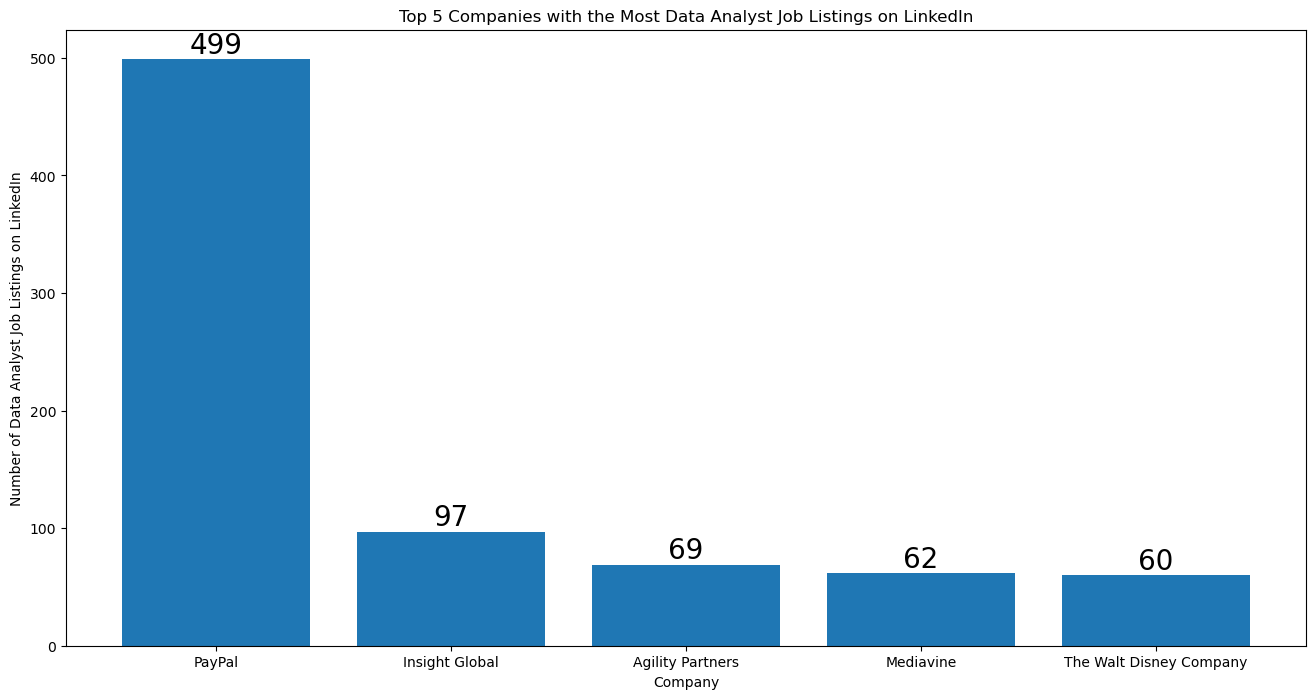

In [16]:
#get list of unique companies
companies = list(usajobs2['df_company'].unique())

com_dict = {}
#function to get count of each category in a dictionary for categorical variables
def count_dict(x, dic):
    if x in dic:
        dic[x] += 1
    else:
        dic[x] = 1

#fill com_dict with the count of each unique company
usajobs2['df_company'].apply(count_dict, args=(com_dict,))

#sort com_dict in descending order of count and then alphabetical order as a tie-breaker
comlist_sorted = sorted(com_dict.items(), key=lambda x: x[0])
comlist_sorted = sorted(comlist_sorted, key=lambda x: x[1], reverse=True)

#unzip comlist_sorted to get a list containing 2 tuples: one for all the company names, one for all the counts
comname_sorted, comcount_sorted = list(zip(*comlist_sorted))

#take top 5 companies with the highest job listing count
top5_comname = comname_sorted[:5]
top5_comcount = comcount_sorted[:5]

#barplot for top 5 companies with highest job listing counts
plt.figure(figsize=(16, 8))
plt.bar(top5_comname, top5_comcount)
for i in range(len(top5_comname)):
    plt.text(i, top5_comcount[i] + 5, top5_comcount[i], ha='center', size=20)
plt.xlabel('Company')
plt.ylabel('Number of Data Analyst Job Listings on LinkedIn')
plt.title('Top 5 Companies with the Most Data Analyst Job Listings on LinkedIn')
plt.show()

In [17]:
import statistics

print('Number of unique companies: ', len(companies))
print('Mean number of data analyst job listings on LinkedIn by a company: ', len(usajobs)/len(companies))
print('Median number of data analyst job listings on LinkedIn by a company: ', statistics.median(comcount_sorted))

Number of unique companies:  171
Mean number of data analyst job listings on LinkedIn by a company:  16.637426900584796
Median number of data analyst job listings on LinkedIn by a company:  3


From the above analysis of the 'df_company' column, we can tell that there are 171 unique companies with 'data analyst' job listings featured in this LinkedIn dataset. The mean number of data analyst job listings on LinkedIn by a company is around 17 (rounded to nearest whole number), however, the median number of data analyst job listings by a company is significantly smaller at merely 3. The fact that the mean and median are so different is a good sign that there are extreme outliers, in particular, outliers whose job listing count is extremely large that it affects the mean and pulls it up.

Taking a look at the bar plot of top 5 companies with the most number of data analyst job listings, it is easy to observe what was stated. PayPal has an extremely high job listing count of 499, and companies such as Insight Global also has a high count of 97. These companies are extreme outliers since their job listing counts are significantly larger than the median count of 3.

That being said, for people in the United States who are seeking for data analyst jobs, the 5 companies displayed in the bar plot (PayPal, Insight Global, Agility Partners Company, Mediavine, The Walt Disney Company) have the most number of data analyst jobs open for application on LinkedIn. Hence, there might be a higher chance for one to get the job if they apply for a data analyst role in these 5 companies.

# Analysing modes of work (onsite/remote/hybrid)

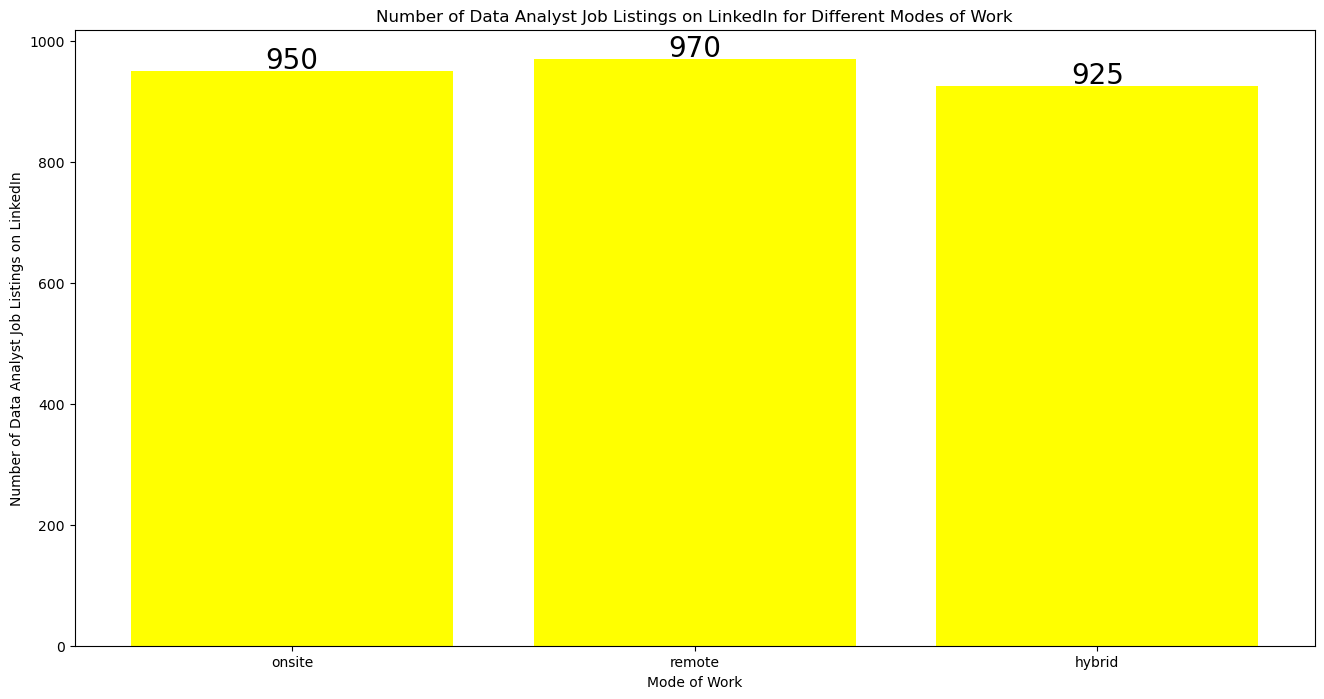

In [18]:
#get list of unique work modes: ['onsite', 'remote', 'hybrid']
work_modes = list(usajobs2['df_onsite_remote'].unique())

mode_dict = {}

#fill mode_dict with the count of each unique work mode
usajobs2['df_onsite_remote'].apply(count_dict, args=(mode_dict,))

#get list from mode_dict
modecount_list = list(mode_dict.items())

#unzip modecount_list to get a list containing 2 tuples: one for all the work modes, one for all the counts
modenames, modecount = list(zip(*modecount_list))

#barplot for the work modes
plt.figure(figsize=(16, 8))
plt.bar(modenames, modecount, color='yellow')
for i in range(len(modenames)):
    plt.text(i, modecount[i] + 5, modecount[i], ha='center', size=20)
plt.xlabel('Mode of Work')
plt.ylabel('Number of Data Analyst Job Listings on LinkedIn')
plt.title('Number of Data Analyst Job Listings on LinkedIn for Different Modes of Work')
plt.show()

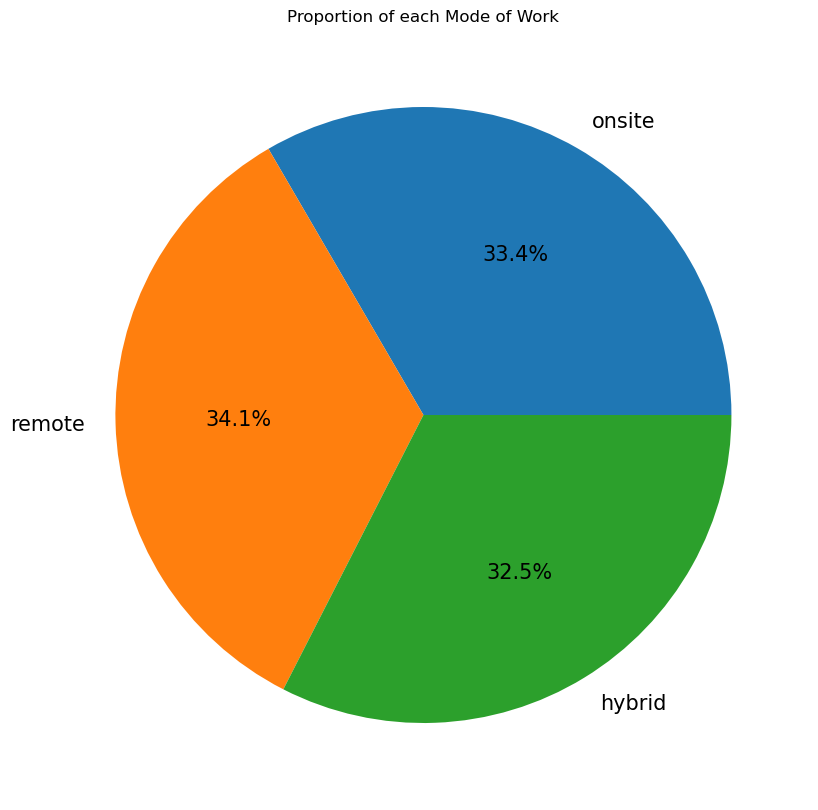

In [19]:
#pie chart for proportion of each mode of work
plt.figure(figsize=(10, 10))
plt.pie(modecount, labels=modenames, autopct='%1.1f%%', textprops={'fontsize': 15})
plt.title('Proportion of each Mode of Work')
plt.show()

From the similar height of bars in the barplot, it can be observed that the distribution of work modes for jobs is almost uniform. There are 950 counts of data analyst job listings with onsite work mode, 970 counts of job listings with remote work mode, and 925 counts of job listings with hybrid work mode. The pie chart also reiterates the same observation, with each proportion of the pie being highly similar in size. Job listings with onsite work mode accounts for 33.4% of all job listings, jobs listings with remote work mode accounts for 34.1%, and the remaining 32.5% belongs to job listings with hybrid work mode.

The near uniform distribution of work modes for data analyst jobs listings on LinkedIn means that potential applicants have a nearly even spread of work modes to choose from when applying for data analyst jobs on LinkedIn. This is a good sign for applicants as they have the ability to choose job listings with their preferred work mode(s). On the flip side, if the work modes for job listings were unevenly distributed, applicants may be stuck with more choices that are not of their preferred work mode(s) and less job listings with their preferred work modes, hence, they would have less freedom to choose when applying for jobs on LinkedIn.

# Analysing Salaries

Number of unique salary ranges:  45


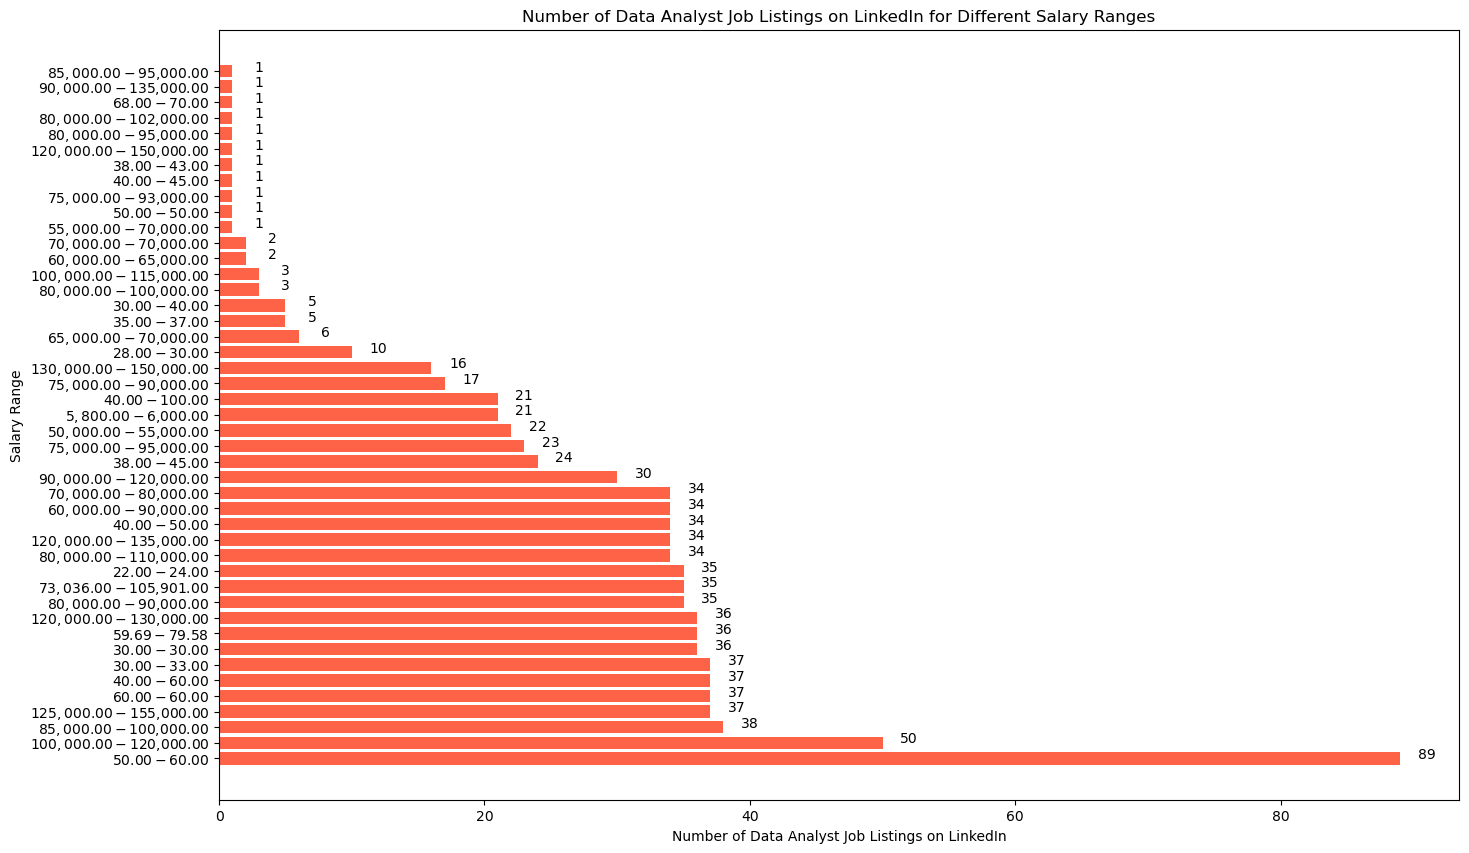

In [20]:
#drop 1916 nan values for salary to get series of non-nan salary ranges
filtered_sal = usajobs2['df_salary'].dropna()

#getting list of unique salary ranges
salaries = list(filtered_sal.unique())
print('Number of unique salary ranges: ', len(salaries))

sal_dict = {}

#fill sal_dict with count of each unique salary range
filtered_sal.apply(count_dict, args=(sal_dict,))

#get list from sal_dict, sorted in ascending order of count
salcount_list = sorted(sal_dict.items(), key=lambda x: x[1], reverse=True)

#unzip salcount_list to get a list containing 2 tuples: one for all the salary ranges, one for all the counts
salranges, salcount = list(zip(*salcount_list))

#barplot for the work modes
plt.figure(figsize=(16, 10))
plt.barh(range(len(salranges)), salcount, color='tomato')
for i in range(len(salranges)):
    plt.text(salcount[i] + 2, i, salcount[i], ha='center', size=10)
plt.yticks(range(len(salranges)), salranges)
plt.ylabel('Salary Range')
plt.xlabel('Number of Data Analyst Job Listings on LinkedIn')
plt.title('Number of Data Analyst Job Listings on LinkedIn for Different Salary Ranges')
plt.show()

From y-axis of the horizontal bar plot above, we can observe that there are many unique salary ranges, in particular there are 45 unique salary ranges. In addition, the ranges have a great spread as there are low salary ranges like 22.00-24.00 in the dataset and also high salary ranges like 125,000.00-155,000.00. From the height of the bars, we can tell that the salary range with the most number of data analyst job listings is 50.00-60.00 with a count of 89. In fact, other lower salary ranges such as 60.00-60.00 and 40.00-60.00 also have quite a significant count of roughly 30+ job listings on LinkedIn. Higher salary ranges such as 100,000.00-120,000.00 that fall between 70,000.00 and 155,000.00 also have relatively high count of job listings on LinkedIn.

The above bar plot quite clearly shows all the unique salary ranges found in the dataset and the count of data analyst job listings for each of them. In this way, salary is treated as a categorical variable. However, more often, salary is treated as a continuous quantitative variable. If we were to convert each salary range to a float value by summing the minimum and maximum of the range and dividing by 2, salary is converted to a quantative variable that can be visualised in other ways such as using a histogram.

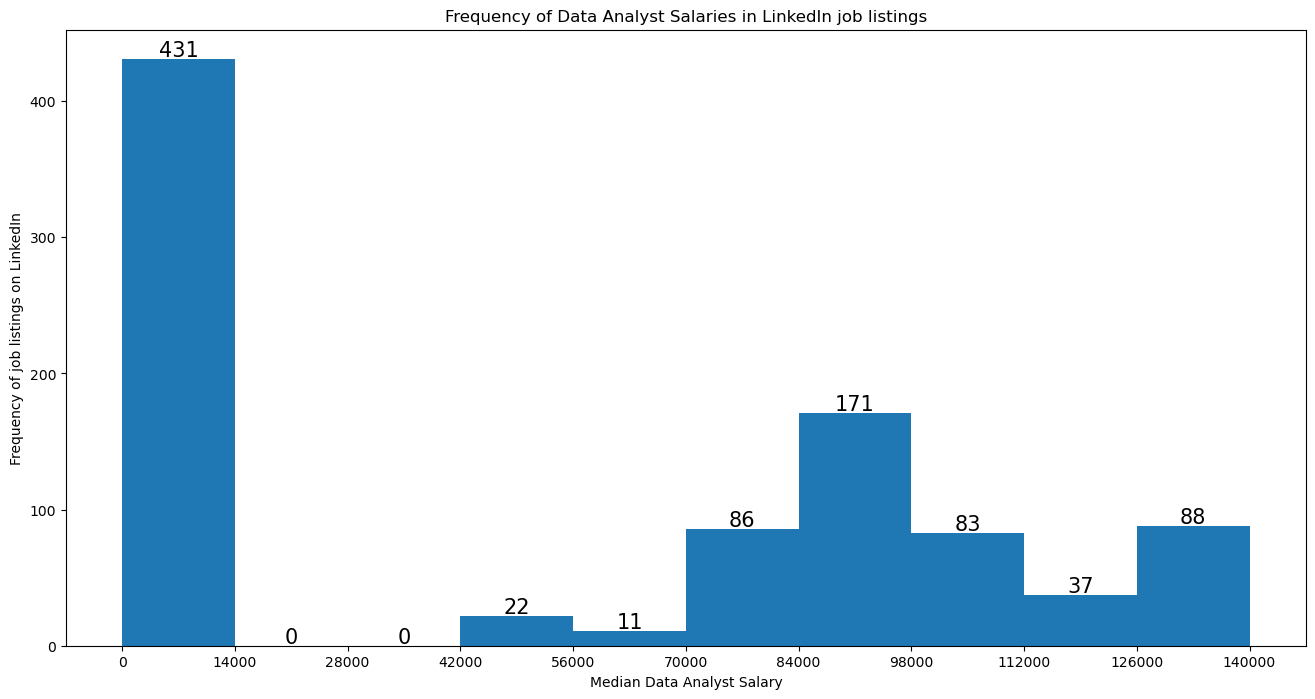

In [21]:
#converting the non-nan salaries of type 'str' to type 'float'
#by summing the min and max in each salary range and dividing by 2
def get_midsal(x):
    salrange_list = (re.split('\-\$|\$', x))[1:]
    salrange_minmax = []
    for s in salrange_list:
        finval = 0
        split_period = re.split('\.', s)
        cents = float(split_period[-1]) * 0.01
        finval += cents
        split_comma = re.split(',', split_period[0])
        for i in range(len(split_comma)):
            numval = float(split_comma[i])
            thousand = len(split_comma) - (i + 1)
            for t in range(thousand):
                numval *= 1000
            finval += numval

        salrange_minmax.append(finval)
    min_sal, max_sal = salrange_minmax
    return (min_sal + max_sal) / 2

filtered_midsal = filtered_sal.apply(get_midsal)

#histogram of filtered_midsal
plt.figure(figsize=(16, 8))
n, bins, patches = plt.hist(filtered_midsal)
plt.xticks(range(0, 140001, 14000), range(0, 140001, 14000))
for i in range(len(n)):
    xcoord = (bins[i] + bins[i + 1]) / 2
    plt.text(xcoord, n[i] + 2, int(n[i]), ha='center', size=15)
plt.xlabel('Median Data Analyst Salary')
plt.ylabel('Frequency of job listings on LinkedIn')
plt.title('Frequency of Data Analyst Salaries in LinkedIn job listings')
plt.show()

From the histogram above, it is reemphasised that there is a good spread of salaries for the data analyst job listings on LinkedIn from the bar for the 0-14000 bin to the bar for the 126000-140000 bin. There is the greatest number of job listings with median salaries from 0 to 14000, at a count of 431. Following that, there is the second greatest number of job listings with median salaries from 84000 to 98000, at a count of 171. Then, 126000-140000 has a count of 88, 70000-84000 has a count of 86, and 98000-112000 has a count of 83, which further proves the observation from the horizontal bar plot that there are quite a significant proportion of data analyst job listings on LinkedIn with higher salaries ranging from 70000-155000.

According to https://www.indeed.com/career/data-analyst/salaries, the average salary per year for a data analyst in the United States is 
14000, which is something that can be further investigated to know the reasons behind the presence of low salaries, such as perhaps inconsistency of units for salaries.

# Analysing Seniority Levels

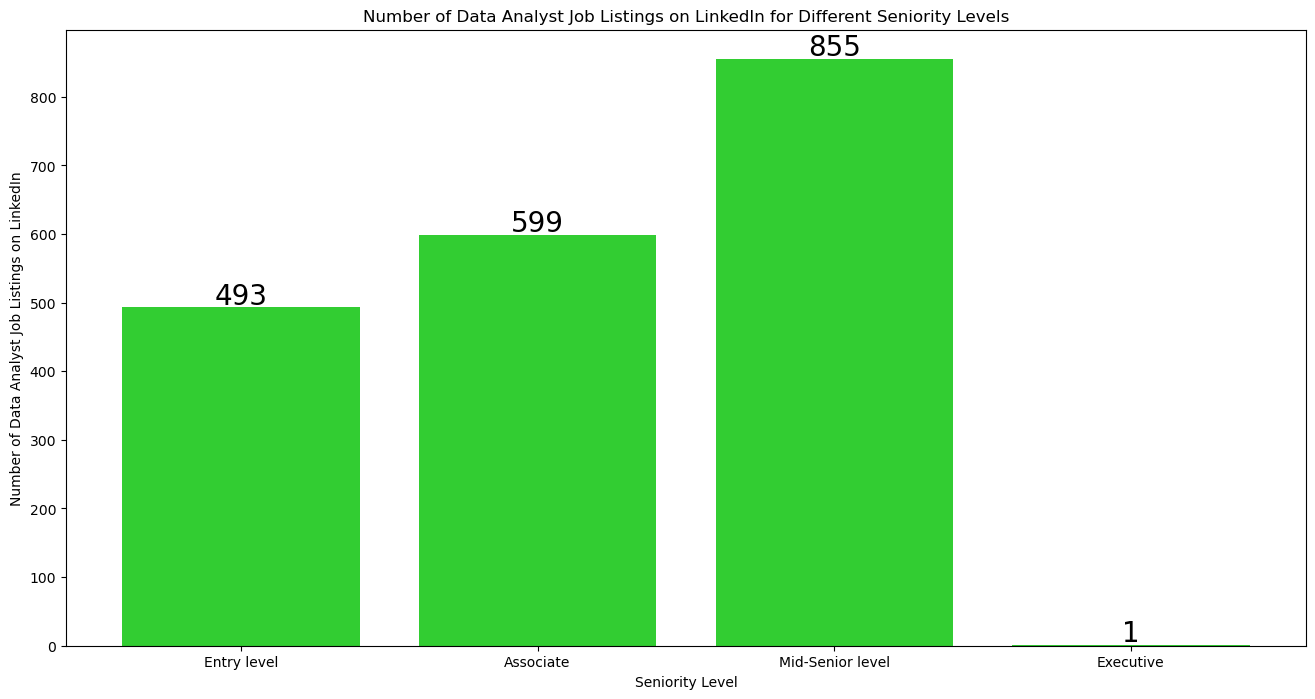

In [22]:
#drop all the 'NAN' values and 'Not Applicable' values
filtered_senior = usajobs2['Seniority level']
filtered_senior = filtered_senior[(filtered_senior != 'Not Applicable') & (filtered_senior != 'NAN')]

#get list of unique seniority levels
senior_lvls = list(filtered_senior.unique())

senior_dict = {}

#fill senior_dict with count of each unique seniority level
filtered_senior.apply(count_dict, args=(senior_dict,))

#get list from senior_dict
seniorcount_list = list(senior_dict.items())

#unzip seniorcount_list to get a list containing 2 tuples: one for all the seniority levels, one for all the counts
seniorities, seniorcount = list(zip(*seniorcount_list))

#bar plot for the seniority levels
plt.figure(figsize=(16, 8))
plt.bar(seniorities, seniorcount, color='limegreen')
for i in range(len(seniorities)):
    plt.text(i, seniorcount[i] + 5, seniorcount[i], ha='center', size=20)
plt.xlabel('Seniority Level')
plt.ylabel('Number of Data Analyst Job Listings on LinkedIn')
plt.title('Number of Data Analyst Job Listings on LinkedIn for Different Seniority Levels')
plt.show()

From the bar plot above, we can tell that generally there are a substantial number of job listings on LinkedIn for entry level, associate level, and mid-senior level data analyst jobs. There is the most number of mid-senior level data analyst job listings at a count of 855, followed by associate level data analyst job listings at a count of 599, and then entry level data analyst job listings at a count of 493. Hence, applicants with more relevant years of work experience and are seeking for data analyst jobs of higher seniority like mid-senior level have a greater number of job listings to choose from and apply for. This may mean that they have a higher chance of getting a data analyst job of higher seniority, as compared to applicants with little relevant work experience who can only seek for entry level data analyst jobs.

It seems like there is a trend that as the seniority level increases, the number of jobs listings increases. However, this trend does not completely hold due to the executive level data analyst job listings. There is only 1 executive level data analyst job listed on LinkedIn. This small number makes sense given that typically companies do not recruit such high seniority executive roles via external recruitment from platforms like LinkedIn, instead recruitment executive level jobs are typically done internally within the company to pick from employees with sufficient company knowledge and relevant work experience.

# Analysing Employment Types

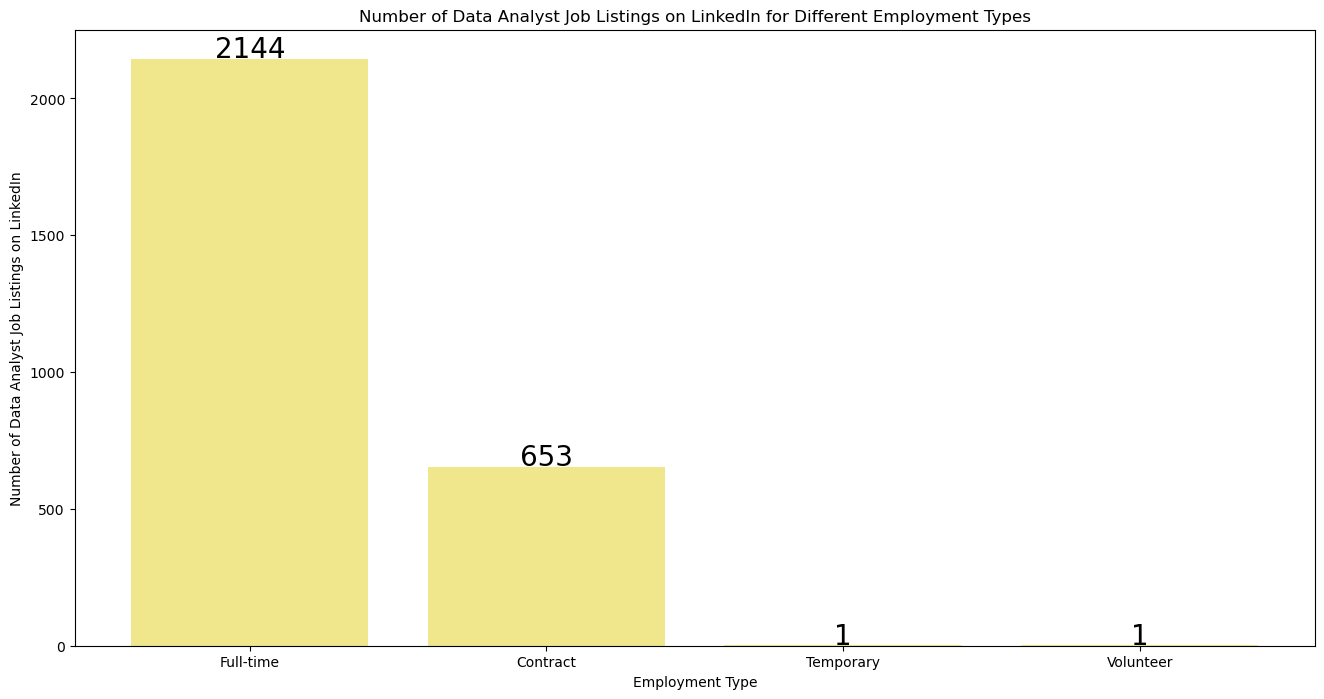

In [23]:
#drop all the 'NAN' values
filtered_emtypes = usajobs2['Employment type']
filtered_emtypes = filtered_emtypes[filtered_emtypes != 'NAN']

#get list of unique employment types
emtypes = list(filtered_emtypes.unique())

emtype_dict = {}

#fill emtype_dict with count of each unique employment type
filtered_emtypes.apply(count_dict, args=(emtype_dict,))

#get list from senior_dict
emtypecount_list = list(emtype_dict.items())

#unzip emtypecount_list to get a list containing 2 tuples: one for all the employment types, one for all the counts
emtypenames, emtypecount = list(zip(*emtypecount_list))

#bar plot for the seniority levels
plt.figure(figsize=(16, 8))
plt.bar(emtypenames, emtypecount, color='khaki')
for i in range(len(emtypenames)):
    plt.text(i, emtypecount[i] + 5, emtypecount[i], ha='center', size=20)
plt.xlabel('Employment Type')
plt.ylabel('Number of Data Analyst Job Listings on LinkedIn')
plt.title('Number of Data Analyst Job Listings on LinkedIn for Different Employment Types')
plt.show()

From the bar plot above, we can tell that there is the most number of full-time data analyst job listings on LinkedIn with a count of 2144, followed by contract data analyst jobs with the second most number of listings at a count of 653. Temporary and volunteer data analyst jobs only have 1 listing each on LinkedIn.

It is worth noting that though contract data analyst jobs have the second most number of listings on LinkedIn, this number is only less than half of the number of full-time data analyst job listings. Hence, we can observe that there is a very high demand from companies for full-time data analysts, relative to data analysts of other employment types. This can mean that applicants who are willing to commit to a full-time data analyst job have a higher chance of being employed as compared to applicants who are only seeking for contract/temporary/volunteer data analyst jobs.

# Analysing Industries

[('indus_Software Development', 738), ('indus_Financial Services', 667), ('indus_IT Services', 635), ('indus_IT Consulting', 635), ('indus_Technology', 627), ('indus_Information', 627), ('indus_Internet', 627), ('indus_Advertising Services', 196), ('indus_Staffing', 128), ('indus_Recruiting', 128), ('indus_Hospitals', 127), ('indus_Health Care', 127), ('indus_Retail Apparel', 101), ('indus_Fashion', 101), ('indus_Pharmaceutical Manufacturing', 99), ('indus_Business Consulting', 95), ('indus_Services', 95), ('indus_Banking', 80), ('indus_Retail', 75), ('indus_Biotechnology Research', 68), ('indus_Medical Equipment Manufacturing', 66), ('indus_Animation', 57), ('indus_Post-production', 57), ('indus_Insurance', 54), ('indus_Motor Vehicle Manufacturing', 40), ('indus_Government Administration', 39), ('indus_Investment Management', 39), ('indus_Telecommunications', 37), ('indus_Manufacturing', 37), ('indus_Savings Institutions', 36), ('indus_Retail Gasoline', 36), ('indus_Renewable Energy S

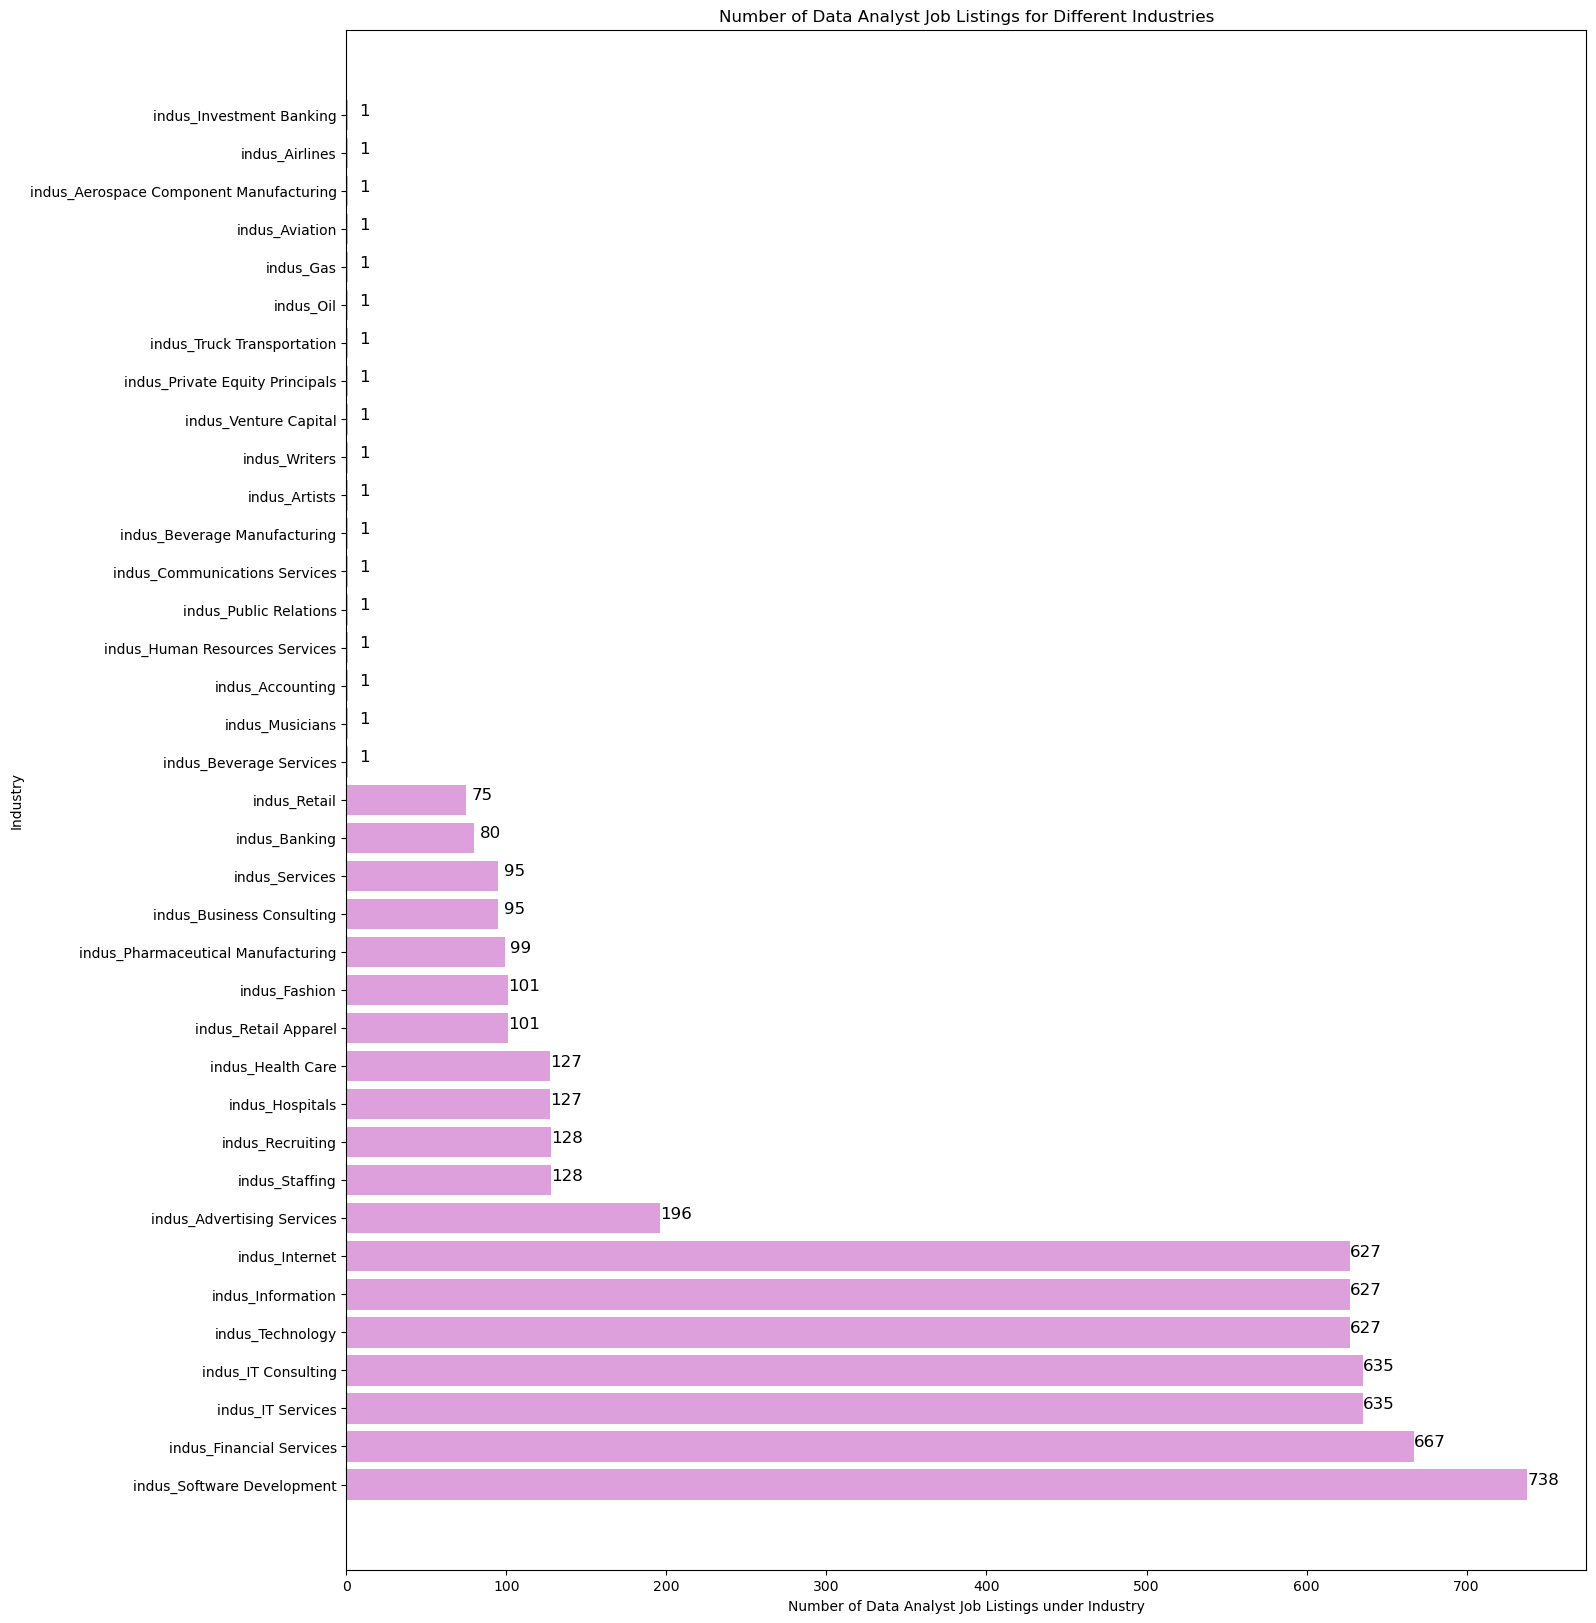

In [24]:
#get list of non-nan industries
filtered_indus = list(filter(lambda x: x != 'NAN', industry_cats))

#add 'indus_' as a prefix to each element in filtered_indus to match the industry column names in usajobs
filtered_indus = list(map(lambda x: 'indus_' + x, filtered_indus))

#get dataframe of all the industry columns
indus_df = usajobs2[filtered_indus]

induscount_dict = {}

#function to get the number of job listings under a certain industry and add to induscount_dict
def add_induscount(col):
    count = np.sum(col)
    induscount_dict[col.name] = count
    
#fill induscount_dict with counts of job listings for each industry column in indus_df
indus_df.apply(add_induscount, axis=0)

#get list from induscount_dict, sorted in descending order of count
induscount_deslist = sorted(induscount_dict.items(), key=lambda x: x[1], reverse=True)
print(induscount_deslist)

#get list of industries with high counts of >=627
indus_highcount = induscount_deslist[:7]

#get list of industries with mid-tier counts of >=75 but <627
indus_midcount = induscount_deslist[7:19]

#get list of industries with low counts of 1
indus_lowcount = induscount_deslist[-18:]

#get unzipped list containing 2 tuples: one for all the industries, one for all the counts
indusnames, induscounts = list(zip(*indus_highcount, *indus_midcount, *indus_lowcount))

#bar plot of industries
plt.figure(figsize=(16, 20))
plt.barh(indusnames, induscounts, color='plum')
for i in range(len(indusnames)):
    plt.text(induscounts[i] + 10, i, induscounts[i], ha='center', size=12)
plt.xlabel('Number of Data Analyst Job Listings under Industry')
plt.ylabel('Industry')
plt.title('Number of Data Analyst Job Listings for Different Industries')
plt.show()

From the horizontal bar plot above, we can tell that many (above 600) of the data analyst job listings fall under industries related to technology such as software development, IT consulting, Information, Internet. This makes sense given that the data analyst job is one of the well-known jobs in the technology industry. There are also a substantial number of data analyst job listings falling under industries such as advertising, staffing, healthcare, retail, business consulting, banking, and more. Often, the job listings fall under industries related to technology along with the industries just mentioned like healthcare. Hence, there is a higher demand for data analysts who are willing to work under industries like healthcare and technology combined, retail and technology combined, advertising and technology combined etc, and applicants can perhaps hone their knowledge of these combinations of industries to be more qualified and increase their chances of landing a job.

On the other hand, there are industries such as public relations, artists, musicians, writers, aviation, beverage manufacturing that only found in 1 data analyst job listing on LinkedIn. This also makes sense since these industries do not often get matched with the data analyst role and technology industry, as compared to industries like healthcare and retail. Hence, these industries also do not have as high a demand for data analysts and it might be more difficult and competitive for applicants to land a job under these industries.

# Analysing Job Functions

[('func_Information Technology', 2263), ('func_Analyst', 695), ('func_Engineering', 125), ('func_Advertising', 107), ('func_Strategy/Planning', 91), ('func_Finance', 86), ('func_Consulting', 74), ('func_Research', 72), ('func_Marketing', 63), ('func_General Business', 61), ('func_Sales', 60), ('func_Project Management', 58), ('func_Other', 38), ('func_Production', 37), ('func_Design', 37), ('func_Business Development', 36), ('func_Education', 18), ('func_Public Relations', 5), ('func_Writing/Editing', 4), ('func_Administrative', 3), ('func_Health Care Provider', 2), ('func_Customer Service', 1), ('func_Human Resources', 1)]


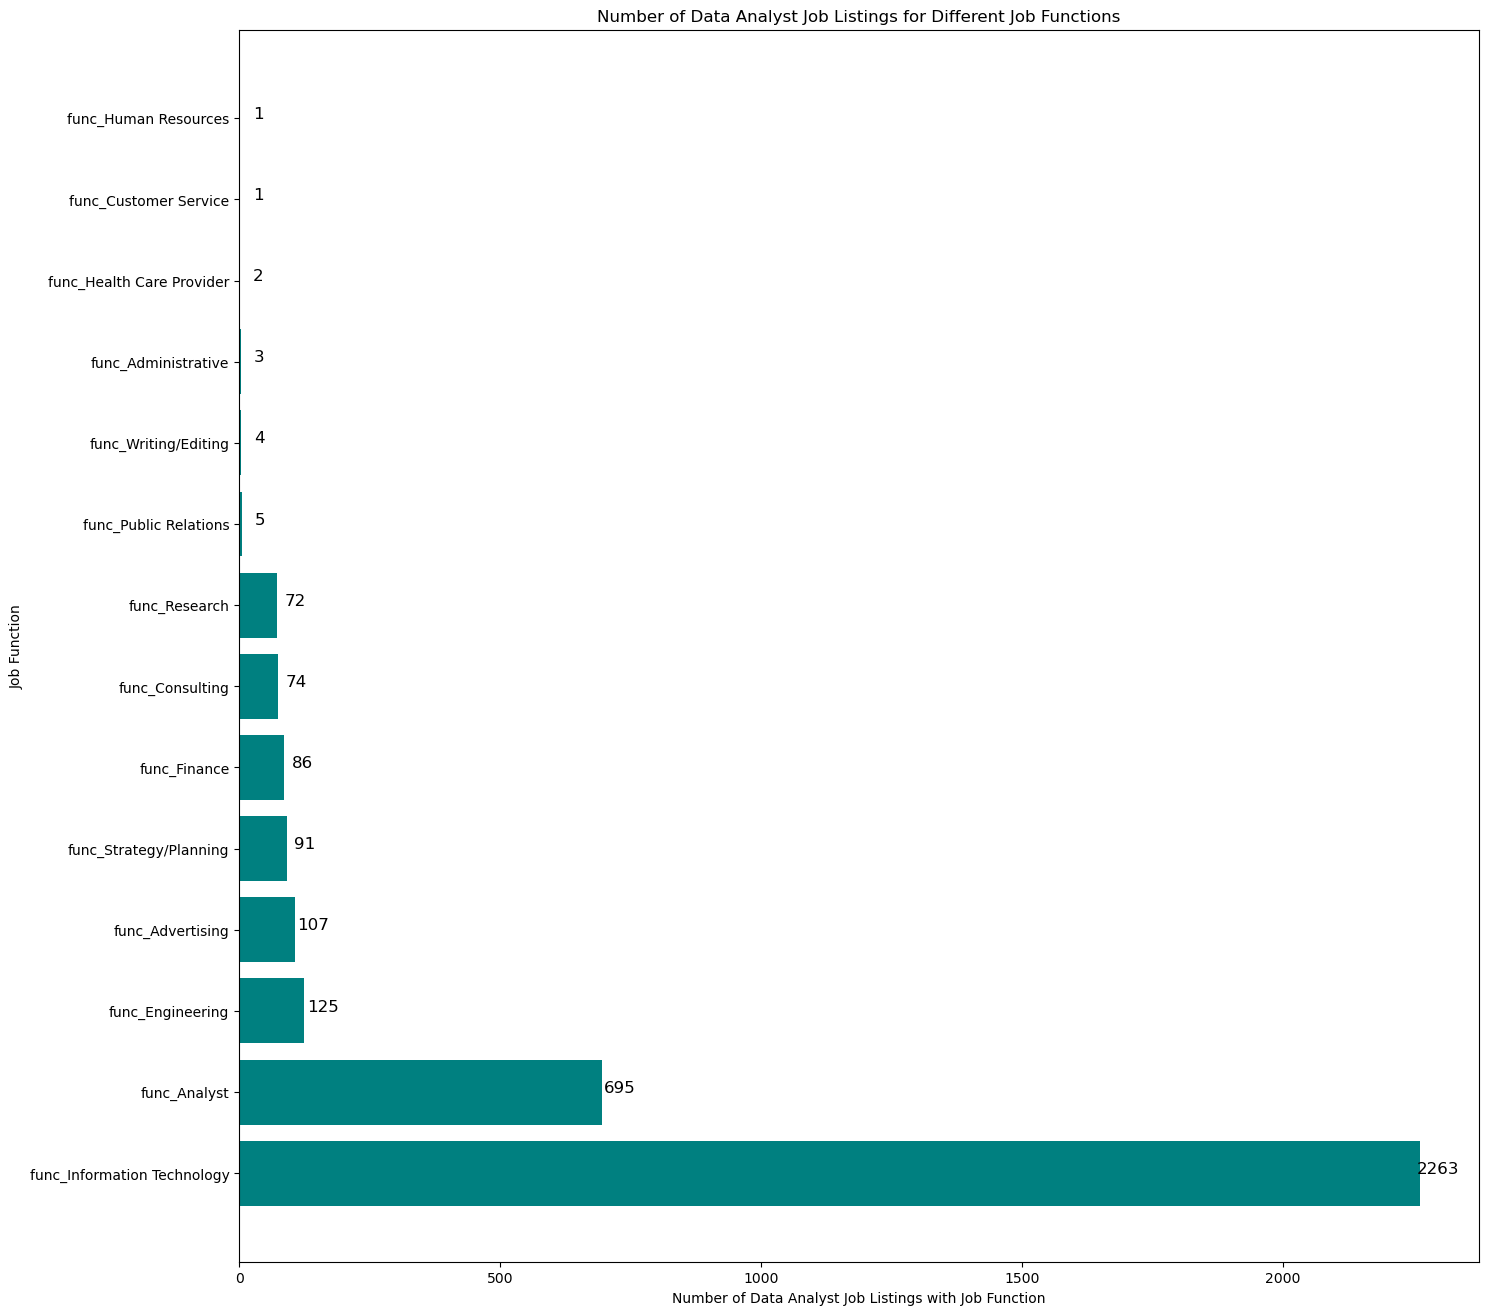

In [25]:
#get list of non-nan job functions
filtered_jobfunc = list(filter(lambda x: x != 'NAN', jobfuncs))

#add 'func_' as a prefix to each element in filtered_jobfunc to match the job function column names in usajobs
filtered_jobfunc = list(map(lambda x: 'func_' + x, filtered_jobfunc))

#get dataframe of all the job function columns
jobfunc_df = usajobs2[filtered_jobfunc]

jobfunccount_dict = {}

#function to get the number of job listings for a certain job function and add to jobfunccount_dict
def add_jobfunccount(col):
    count = np.sum(col)
    jobfunccount_dict[col.name] = count
    
#fill jobfunccount_dict with counts of job listings for each job function column in jobfunc_df
jobfunc_df.apply(add_jobfunccount, axis=0)

#get list from jobfunccount_dict, sorted in descending order of count
jobfunccount_deslist = sorted(jobfunccount_dict.items(), key=lambda x: x[1], reverse=True)
print(jobfunccount_deslist)

#get list of job functions with high counts of >70
jobfunc_highcount = jobfunccount_deslist[:8]

#get list of job functions with low counts of <=5
jobfunc_lowcount = jobfunccount_deslist[-6:]

#get unzipped list containing 2 tuples: one for all the job functions, one for all the counts
jobfuncnames, jobfunccounts = list(zip(*jobfunc_highcount, *jobfunc_lowcount))

#bar plot of job functions
plt.figure(figsize=(16, 16))
plt.barh(jobfuncnames, jobfunccounts, color='teal')
for i in range(len(jobfuncnames)):
    plt.text(jobfunccounts[i] + 35, i, jobfunccounts[i], ha='center', size=12)
plt.xlabel('Number of Data Analyst Job Listings with Job Function')
plt.ylabel('Job Function')
plt.title('Number of Data Analyst Job Listings for Different Job Functions')
plt.show()

From the horizontal bar plot above, we can tell that there is an extremely large number of 2263 data analyst job listings with the job function of 'Information Technology'. Similar to the analysis of industries previously, this is to be expected since the job scope of a data analyst is categorised in the job function of 'Information Technology'. The job function of 'Analyst' with the next highest number of job listings at 695 and the job function of 'Engineering' with the 3rd highest number of job listings at 125 also adapts the same reasoning for their high counts. In addition, we can observe that there is a substantial number of data analyst job listings for job functions such as advertising, finance, consulting, strategy/planning. This observation aligns with the one made from the industry analysis where there were relatively many job listings under industries like advertising, staffing, retail, consulting, banking etc. Hence, it further emphasises the point made that there is a high demand for data analysts with job functions like advertising, finance, consulting etc, and applicants may increase their chances of getting employed by learning more about such job functions beforehand.

On the other hand, there are job functions such as writing/editing, public relations, customer service that are found in very few (<=5) job listings. For functions such as writing/editing and public relations, their low count of job listings also align with the observation from the industry analysis where the writing and public relations industries had very few job listings. Hence, it reemphasises the fact that since information technology is not often matched with job functions like writing, there is a lower demand for data analysts with such job functions and it may make such job listings more competitive for applicants to get successfully.

# Analysing Job Descriptions

In [26]:
#get data frame of vectorized job descriptions
desc_df = pd.DataFrame(desc_vec.toarray(), columns=vectorizer.get_feature_names_out())

wordcount_dict = {}

#function to get the count for a certain vectorized word and add to wordcount_dict
def add_wordcount(col):
    count = np.sum(col)
    wordcount_dict[col.name] = count
    
#fill wordcount_dict with counts for each word column in desc_df
desc_df.apply(add_wordcount, axis=0)

#get list from wordcount_dict, sorted in descending order of count
wordcount_deslist = sorted(wordcount_dict.items(), key=lambda x: x[1], reverse=True)
print(wordcount_deslist)

#get list of selected words with high counts in the dataset
selwords_highcount = wordcount_deslist

[('data', 28776), ('business', 10273), ('experience', 10114), ('team', 7865), ('work', 7694), ('paypal', 7285), ('analysis', 6149), ('we', 5460), ('analyst', 4623), ('skill', 4293), ('you', 4225), ('analytics', 4166), ('product', 3724), ('the', 3448), ('financial', 3412), ('ability', 3378), ('year', 3289), ('support', 3233), ('risk', 3148), ('opportunity', 3119), ('requirement', 2978), ('including', 2968), ('information', 2910), ('status', 2887), ('sql', 2847), ('service', 2844), ('and', 2794), ('job', 2761), ('based', 2748), ('health', 2726), ('benefit', 2713), ('role', 2709), ('in', 2701), ('working', 2682), ('technology', 2585), ('process', 2563), ('tool', 2547), ('develop', 2509), ('new', 2489), ('global', 2480), ('analytical', 2478), ('help', 2461), ('employee', 2439), ('solution', 2300), ('to', 2281), ('customer', 2246), ('this', 2222), ('management', 2213), ('disability', 2168), ('make', 2155), ('platform', 2107), ('or', 2106), ('client', 2094), ('dashboard', 2087), ('technical'

Each word in this list of words has a high word count in the LinkedIn job listings, which helps to give insight as to what are some common requirements for data analysts by current employers and what current employers look for in a data analyst in their company.

For example, there are words such as develop, make, management, reporting, create, build, model, solution, complex, which indicate what are the common things data analysts are expected to do on the job like building complex models let's say.

There are also words such as data, analysis, analytics, sql, dashboard, insight, visualization, tableau, python, excel, which indicate what are some common knowledge areas that employers want data analysts to be familiar with i.e. employers want data analysts to be familiar with sql, tableau, python, microsoft excel, and data analytics to be able to create data visualizations like dashboards and extract useful insights from them.

There are words such as experience, team, work, driven, responsible, leadership, proactive, which indicate what are some common qualities/traits that employers look for in data analysts i.e. employers want data analysts which are experienced, can work in teams, driven, responsible, proactive, and have leadership.

Lastly, there are words such as business, product, financial, risk, health, technology, engineering, which indicate what are common industries and functions that data analysts can look forward to joining. Some of these words are reflected in the analysis for industries and for job functions such as health, technology, engineering etc, which reiterates the high demand for data analysts from such industries and for such job functions.

# Unsupervised Machine Learning

In [27]:
#get dataframe of one-hot encoded industry, one-hot encoded job function, and vectorized word columns
usajobs3 = indus_df.astype('int64').merge(jobfunc_df.astype('int64'), how='inner', left_index=True, right_index=True)
usajobs3 = usajobs3.merge(desc_df, how='inner', left_index=True, right_index=True)
usajobs3

,indus_Software Development,indus_Technology,indus_Information,indus_Internet,indus_Financial Services,indus_Savings Institutions,indus_Hospitals,indus_Health Care,indus_Government Administration,indus_Transportation,...,youyou,yr,yrs,zeal,zealand,zen,zendesk,zerohungerzerowaste,zip,zone
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2841,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2842,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# K-Means Clustering1

In [28]:
from sklearn.cluster import KMeans

#get usajobs3 transformed to a cluster-distance space
kmeans = KMeans(n_init='auto').fit(usajobs3)
transformed_X = pd.DataFrame(kmeans.transform(usajobs3), columns=kmeans.get_feature_names_out())
transformed_X

,kmeans0,kmeans1,kmeans2,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7
0,29.120376,2.875761e+01,0.000000,30.793704,30.435528,28.553831,36.221541,37.762415
1,29.120376,2.875761e+01,0.000000,30.793704,30.435528,28.553831,36.221541,37.762415
2,35.240014,6.743496e-07,28.757608,36.296316,36.752934,35.306977,42.011903,43.324358
3,35.240014,6.743496e-07,28.757608,36.296316,36.752934,35.306977,42.011903,43.324358
4,16.982094,3.889730e+01,33.852622,22.575909,26.158829,21.627984,29.154759,34.205263
...,...,...,...,...,...,...,...,...
2840,19.660956,3.844477e+01,34.073450,11.016047,26.113837,18.911274,28.548205,36.592349
2841,28.567536,4.444097e+01,38.052595,29.383735,26.174516,24.461928,34.612137,36.083237
2842,36.631224,4.884670e+01,42.930176,39.326413,29.596782,32.950707,40.951190,38.845849
2843,18.973411,3.875564e+01,33.211444,17.330758,21.437688,16.978649,27.549955,32.015621


In [29]:
#get dataframe of kmeans cluster centers
kmeans_centers = pd.DataFrame(kmeans.cluster_centers_, index=kmeans.get_feature_names_out(), columns=usajobs3.columns)
kmeans_centers

,indus_Software Development,indus_Technology,indus_Information,indus_Internet,indus_Financial Services,indus_Savings Institutions,indus_Hospitals,indus_Health Care,indus_Government Administration,indus_Transportation,...,youyou,yr,yrs,zeal,zealand,zen,zendesk,zerohungerzerowaste,zip,zone
kmeans0,0.227545,1.110223e-16,1.110223e-16,1.110223e-16,-2.775558e-17,2.155689e-01,2.215569e-01,2.215569e-01,2.215569e-01,-5.204170e-18,...,-1.626303e-19,-5.204170e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,-8.673617e-19,-1.626303e-19,-1.626303e-19,-1.626303e-19,5.988024e-03
kmeans1,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.775558e-17,1.040834e-16,1.040834e-16,2.255141e-17,1.214306e-17,...,-1.626303e-19,-5.204170e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,6.071532e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,2.428613e-17
kmeans2,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.081668e-17,-4.857226e-17,-4.857226e-17,1.561251e-17,-1.561251e-17,...,-1.626303e-19,-5.204170e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,1.734723e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,6.938894e-18
kmeans3,0.078652,1.872659e-03,1.872659e-03,1.872659e-03,1.067416e-01,1.387779e-17,3.558052e-02,3.558052e-02,9.363296e-04,1.040834e-17,...,-1.626303e-19,2.902622e-02,9.363296e-04,9.363296e-04,-1.626303e-19,4.681648e-03,9.363296e-04,-1.626303e-19,9.363296e-04,9.363296e-04
kmeans4,0.055556,3.364198e-01,3.364198e-01,3.364198e-01,2.775558e-17,3.469447e-18,-3.469447e-17,-3.469447e-17,3.086420e-03,1.018519e-01,...,-1.626303e-19,-5.204170e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,-1.084202e-18,-1.626303e-19,-1.626303e-19,-1.626303e-19,5.246914e-02
kmeans5,0.149931,3.713893e-02,3.713893e-02,3.713893e-02,8.803301e-02,0.000000e+00,7.152682e-02,7.152682e-02,1.561251e-17,5.204170e-18,...,1.375516e-03,1.375516e-03,-1.626303e-19,-1.626303e-19,1.375516e-03,3.903128e-18,-1.626303e-19,1.375516e-03,-1.626303e-19,1.375516e-03
kmeans6,0.000000,2.775558e-17,2.775558e-17,2.775558e-17,0.000000e+00,3.469447e-18,6.938894e-18,6.938894e-18,3.469447e-18,3.469447e-18,...,-5.421011e-20,-1.734723e-18,-5.421011e-20,-5.421011e-20,-5.421011e-20,4.336809e-19,-5.421011e-20,-5.421011e-20,-5.421011e-20,1.734723e-18
kmeans7,0.000000,-2.775558e-17,-2.775558e-17,-2.775558e-17,0.000000e+00,-1.734723e-18,6.938894e-18,6.938894e-18,3.469447e-18,1.734723e-18,...,-1.084202e-19,-3.469447e-18,-1.084202e-19,-1.084202e-19,-1.084202e-19,-4.336809e-19,-1.084202e-19,-1.084202e-19,-1.084202e-19,-1.734723e-18
